### 0) Import 

In [ ]:
!pip install -U transformers 
!pip install -q sacrebleu==1.2.10 torch pythainlp==2.1.4 mosestokenizer sentencepiece
#!pip install fairseq

import time, os
import pickle
#import html
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline, AutoModelForCausalLM
# from functools import partial
# from collections import defaultdict

# from fairseq.models.transformer import TransformerModel

# from mosestokenizer import MosesTokenizer, MosesDetokenizer
# from pythainlp.tokenize import word_tokenize as th_word_tokenize

# en_word_tokenize = MosesTokenizer('en')
# en_word_detokenize = MosesDetokenizer('en')

# th_word_tokenize = partial(th_word_tokenize, keep_whitespace=False)

# !wget https://github.com/vistec-AI/model-releases/releases/download/SCB_1M%2BTBASE_v1.0/SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0.tar.gz
# !wget https://github.com/vistec-AI/model-releases/releases/download/SCB_1M%2BTBASE_v1.0/SCB_1M+TBASE_th-en_spm-spm_32000-joined_v1.0.tar.gz
# !wget https://github.com/vistec-AI/model-releases/releases/download/SCB_1M%2BTBASE_v1.0/SCB_1M+TBASE_en-th_moses-spm_130000-16000_v1.0.tar.gz
# !wget https://github.com/vistec-AI/model-releases/releases/download/SCB_1M%2BTBASE_v1.0/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0.tar.gz
# !mkdir -p ./mt
# !tar -C ./mt -xvzf SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0.tar.gz
# !tar -C ./mt -xvzf SCB_1M+TBASE_th-en_spm-spm_32000-joined_v1.0.tar.gz
# !tar -C ./mt -xvzf SCB_1M+TBASE_en-th_moses-spm_130000-16000_v1.0.tar.gz
# !tar -C ./mt -xvzf SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0.tar.gz
# !wc -l ./mt/SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0/vocab/dict.en.txt
# !wc -l ./mt/SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0/vocab/dict.th.txt
# !head ./mt/SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0/vocab/dict.th.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 243.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


### pipeline: th_text -> translator -> eng_text -> Chit-Chat model -> eng_text -> translator -> th_text

### 0.1) Load Chit-Chat model

In [ ]:
## Huggingface https://huggingface.co/facebook/blenderbot-400M-distill?text=Hey+my+name+is+Thomas%21+How+are+you%3F

tokenizer = AutoTokenizer.from_pretrained("facebook/blenderbot-400M-distill")

model = AutoModelForSeq2SeqLM.from_pretrained("facebook/blenderbot-400M-distill")

generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

In [ ]:
# Save tokenizer and model to .pkl file
with open('/content/drive/MyDrive/chit-chat/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('/content/drive/MyDrive/chit-chat/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load tokenizer and model
# with open('tokenizer.pkl', 'rb') as f:
#     tokenizer_loaded = pickle.load(f)

# with open('model.pkl', 'rb') as f:
#     model_loaded = pickle.load(f)

# # Check if the loaded tokenizer is the same as the original
# assert str(tokenizer) == str(tokenizer_loaded)
# assert model_loaded.config == model.config
# assert model_loaded.state_dict().keys() == model.state_dict().keys()


### 1.1) Translator: Vistec
__VISTEC-depa AI Research Institute of Thailand__ - [airesearch.in.th](https://www.airesearch.in.th)

In [ ]:
th2en_word2word = TransformerModel.from_pretrained(
                    model_name_or_path='mt/SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0/models/',
                    checkpoint_file='checkpoint.pt',
                    data_name_or_path='mt/SCB_1M+TBASE_th-en_newmm-moses_130000-130000_v1.0/vocab/'

)

In [ ]:
en2th_word2bpe = TransformerModel.from_pretrained(
                    model_name_or_path='mt/SCB_1M+TBASE_en-th_moses-spm_130000-16000_v1.0/models/',
                    checkpoint_file='checkpoint.pt',
                    data_name_or_path='mt/SCB_1M+TBASE_en-th_moses-spm_130000-16000_v1.0/vocab/'
)

In [ ]:
th2en_bpe2bpe = TransformerModel.from_pretrained(
                    model_name_or_path='mt/SCB_1M+TBASE_th-en_spm-spm_32000-joined_v1.0/models/',
                    checkpoint_file='checkpoint.pt',
                    data_name_or_path='mt/SCB_1M+TBASE_th-en_spm-spm_32000-joined_v1.0/vocab/',
                    bpe='sentencepiece',
                    sentencepiece_model='mt/SCB_1M+TBASE_th-en_spm-spm_32000-joined_v1.0/bpe/spm.th.model'
                )

In [ ]:
en2th_bpe2bpe = TransformerModel.from_pretrained(
                    model_name_or_path='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/models/',
                    checkpoint_file='checkpoint.pt',
                    data_name_or_path='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/vocab/',
                    bpe='sentencepiece',
                    sentencepiece_model='mt/SCB_1M+TBASE_en-th_spm-spm_32000-joined_v1.0/bpe/spm.en.model'
)

In [ ]:
def th2eng_vistec(th_text):
  tokenized_sentence = ' '.join(th_word_tokenize(th_text))
  _hypothesis = th2en_bpe2bpe.translate(tokenized_sentence)
  hypothesis = en_word_detokenize([_hypothesis])
  return hypothesis

In [ ]:
def eng2th_vistec(eng_text):
  tokenized_sentence = ' '.join(en_word_tokenize(eng_text))
  hypothesis = en2th_bpe2bpe.translate(tokenized_sentence)
  hypothesis = hypothesis.replace(' ', '').replace('▁', ' ').strip()
  return hypothesis

### 1.2) Translator: Facebook
doc -> [this link](https://github.com/facebookresearch/flores/blob/main/flores200/README.md#languages-in-flores-200)

In [ ]:
tokenizer_tran_fb = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model_tran_fb = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

In [ ]:
def th2eng_fb(th_text):

    inputs = tokenizer_tran_fb(th_text, return_tensors="pt") 

    translated_tokens = model_tran_fb.generate(**inputs, forced_bos_token_id=tokenizer_tran_fb.lang_code_to_id["eng_Latn"], max_length=30) ## change destinated lang with lang_code_to_id
    
    return tokenizer_tran_fb.batch_decode(translated_tokens, skip_special_tokens=True)[0]

In [ ]:
def eng2th_fb(eng_text):

    inputs = tokenizer_tran_fb(eng_text, return_tensors="pt")

    translated_tokens = model_tran_fb.generate(**inputs, forced_bos_token_id=tokenizer_tran_fb.lang_code_to_id["tha_Thai"], max_length=30)## change destnatied lang with lang_code_to_id
    
    return tokenizer_tran_fb.batch_decode(translated_tokens, skip_special_tokens=True)[0]

### 1.3) Translator: Helsinki
Ref -> [Tatoeba](https://github.com/Helsinki-NLP/Tatoeba-Challenge)

In [ ]:
tokenizer_th2eng_hel = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-th-en")

model_th2eng_hel = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-th-en")

tokenizer_eng2th_hel = AutoTokenizer.from_pretrained("Chayawat/opus-mt-en-mul-finetuned-en-to-th")

model_eng2th_hel = AutoModelForSeq2SeqLM.from_pretrained("Chayawat/opus-mt-en-mul-finetuned-en-to-th")

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
# Save tokenizer and model to .pkl file
with open('/content/drive/MyDrive/chit-chat/tokenizer_th2eng_hel.pkl', 'wb') as f:
    pickle.dump(tokenizer_th2eng_hel, f)
with open('/content/drive/MyDrive/chit-chat/tokenizer_eng2th_hel.pkl', 'wb') as f:
    pickle.dump(tokenizer_eng2th_hel, f)

with open('/content/drive/MyDrive/chit-chat/model_th2eng_hel.pkl', 'wb') as f:
    pickle.dump(model_th2eng_hel, f)
with open('/content/drive/MyDrive/chit-chat/model_eng2th_hel.pkl', 'wb') as f:
    pickle.dump(model_eng2th_hel, f)

# # Load tokenizer and model
# with open('tokenizer_th2eng_hel.pkl', 'rb') as f:
#     tokenizer_th2eng_hel_loaded = pickle.load(f)
# with open('tokenizer_eng2th_hel.pkl', 'rb') as f:
#     tokenizer_eng2th_hel_loaded = pickle.load(f)

# with open('model_th2eng_hel.pkl', 'rb') as f:
#     model_th2eng_hel_loaded = pickle.load(f)
# with open('model_eng2th_hel.pkl', 'rb') as f:
#     model_eng2th_hel_loaded = pickle.load(f)

# # Check if the loaded tokenizer is the same as the original
# assert str(tokenizer_th2eng_hel) == str(tokenizer_th2eng_hel_loaded)
# assert model_th2eng_hel_loaded.config == model_th2eng_hel.config
# assert model_th2eng_hel_loaded.state_dict().keys() == model_th2eng_hel.state_dict().keys()

# assert str(tokenizer_eng2th_hel) == str(tokenizer_eng2th_hel_loaded)
# assert model_eng2th_hel_loaded.config == model_eng2th_hel.config
# assert model_eng2th_hel_loaded.state_dict().keys() == model_eng2th_hel.state_dict().keys()


In [ ]:
def th2eng_hel(th_text):
  input_ids = tokenizer_th2eng_hel.encode(th_text, return_tensors="pt", padding=True)

  outputs = model_th2eng_hel.generate(
      input_ids=input_ids,
      max_length=128,
      num_beams=2,
      early_stopping=True
  )

  output_text = tokenizer_th2eng_hel.decode(outputs[0], skip_special_tokens=True)
  return output_text

In [ ]:
input_ids = tokenizer_th2eng_hel.encode('Hello', return_tensors="pt", padding=True)
input_ids

tensor([[   99, 48978,     0]])

In [ ]:
outputs = model_th2eng_hel.generate(
      input_ids=input_ids,
      max_length=128,
      num_beams=2,
      early_stopping=True
  )
outputs

tensor([[62306,  1142,     6,     0]])

In [ ]:
 output_text = tokenizer_th2eng_hel.decode(outputs[0], skip_special_tokens=True)
 output_text

'Hello?'

In [ ]:
def eng2th_hel(eng_text):
  input_ids = tokenizer_eng2th_hel.encode(eng_text, return_tensors="pt", padding=True)

  outputs = model_eng2th_hel.generate(
      input_ids=input_ids,
      max_length=128,
      num_beams=2,
      early_stopping=True
  )

  output_text = tokenizer_eng2th_hel.decode(outputs[0], skip_special_tokens=True)
  return output_text

### 2) Chit-Chat function

#### Top-K
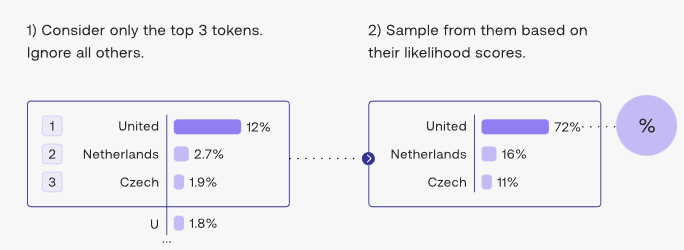

#### Top-P
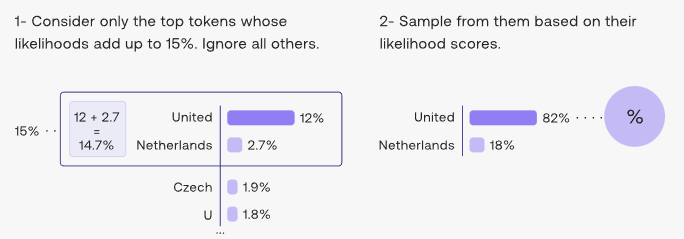

#### Temperature
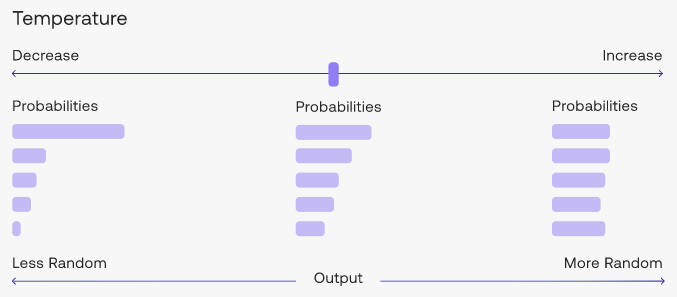

In [ ]:
## Define Hyperparameter
do_sample = True
top_k = 50
num_beams = 5               #Number of search path
no_repeat_ngram_size = 4 
early_stopping = True
max_length = 200            #Maximum numbers of tokens to generate
top_p = 0.95
temperature = 1             #Randomness max:2
num_return_sequences = 1    #Number of anwer

In [ ]:
def chit_chat(text):
  ## Translate Thai text to Eng text
  conver_in = th2eng_hel(text)                  #select translator -> vistec, fb, hel

  ##Inference text on model
  ans = generator(conver_in, do_sample=do_sample, top_k=top_k, num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size, 
    early_stopping=early_stopping, max_length= max_length, top_p=top_p, temperature=temperature, num_return_sequences=num_return_sequences)
  
  output = []

  ## Translate Eng text to Thai text
  for i in range(len(ans)):
    text_out = ans[i]
    conver_out = text_out['generated_text']
    result = eng2th_hel(conver_out)             #select translator -> vistec, fb, hel
    output.append(result)

  return result, conver_in, conver_out

### 3) Evaluation

In [ ]:
test_list = ['วันนี้มีข่าวอะไรน่าสนใจบ้าง',
            'เราไม่เก่งคํานวณจะเรียนรู้เรื่องมั้ย',
            'คนอื่นๆที่เรียนเค้ารู้สึกยังไงกันบ้าง',
            'จำไม่ได้เลย มีอะไรแนะนําบ้าง',
            'พรุ่งนี้ราคาหุ้นจะขึ้นมั้ย',
            'stop'
           ]

In [ ]:
chit_chat_thai = [  "สบายดีไหมคะ?",  "วันนี้อากาศดีจังเลย",  "คุณชื่ออะไรคะ?",  "ทำอะไรอยู่?",  "ร้องเพลงชื่อดังอะไรได้บ้าง?",  "คุณชอบกินอาหารชนิดไหน?",  "ไปเที่ยวที่ไหนบ้าง?",  "มีความสุขกับชีวิตประจำวันมากน้อยแค่ไหน?",  "อยากทำอะไรในวันหยุด?",  "เล่าเรื่องตลกให้ฟังหน่อยได้ไหม?",  "คุณเคยไปเที่ยวต่างประเทศมาก่อนหรือยัง?",  "วันนี้วันดีๆ หรือไม่ดี?",  "ที่สุดของเมนูอาหารที่คุณชอบคืออะไร?",  "คุณชอบดูหนังแนวไหน?",  "คุณชอบอ่านหนังสือเล่มเป็นภาษาไทยหรือเปล่า?",  "เคยเล่นเกมออนไลน์กันหรือไม่?",  "วันนี้วันเสาร์ มีแผนอะไรบ้าง?",  "คุณเคยไปเที่ยวช่วงเทศกาลไหม?",  "อะไรที่คุณอยากซื้อในขณะนี้?",  "เคยไปเที่ยวในจังหวัดไหนบ้าง?", "stop"]


In [ ]:
## Test mode
for text in test_list:
  start = time.time()
  if text == 'stop': 
    break
  else:
    print(f'You: {text}')
    output, conver_in, conver_out = chit_chat(text)
    stop = time.time()
    print(f'You: {conver_in}')
    print(f'Bot:{conver_out}')
    print(f'Bot: {output}')
    print(f'Response Time: {stop-start:.2f} S', '\n')

You: วันนี้มีข่าวอะไรน่าสนใจบ้าง
You: Any interesting news today?
Bot: I got a promotion at my job!  I am so happy!  I have been working so hard!
Bot: ฉันมีโปรโมชั่นในงานของฉัน ฉันมีความสุขมาก ฉันทํางานหนักมาก!
Response Time: 7.81 S 

You: เราไม่เก่งคํานวณจะเรียนรู้เรื่องมั้ย
You: We're not good at calculating.
Bot: I I'm not good with math either, but I'm sure you're better at something else.
Bot: ฉันไม่ดีกับคณิตศาสตร์เช่นกัน แต่ฉันแน่ใจว่าคุณดีกว่าที่อย่างอื่น
Response Time: 6.38 S 

You: คนอื่นๆที่เรียนเค้ารู้สึกยังไงกันบ้าง
You: How did the rest of the students feel?
Bot: They were shocked, but they didn't say anything. I felt bad for them because I didn't know what to do.
Bot: พวกเขาตกใจ แต่พวกเขาไม่ได้พูดอะไรเลย ฉันรู้สึกแย่สําหรับพวกเขาเพราะฉันไม่รู้ว่าจะทําอะไร
Response Time: 8.64 S 

You: จำไม่ได้เลย มีอะไรแนะนําบ้าง
You: I don't remember. What's the suggestion?
Bot: I I am not sure.  I have no idea.  I am so frustrated.
Bot: ฉันไม่แน่ใจอ่ะ ฉันไม่รู้อ่ะ ฉันหงุดหงิดมาก
Response

In [ ]:
## Chit-Chat mode
while True:
  text = input('You: ')
  start = time.time()
  if text == 'stop': 
    break
  else:
    output, conver_in, conver_out = chit_chat(text)
    stop = time.time()
    print(f'You: {conver_in}')
    print(f'Bot:{conver_out}')
    print(f'Bot: {output}')
    print(f'Response Time: {stop-start:.2f} S', '\n')

You: สวัสดีครับ
You: Hello.
Bot: Hi, how are you doing today? I'm doing well, how about you? Do you have any hobbies?
Bot: สวัสดีค่ะ วันนี้เป็นยังไงบ้างคะ ฉันเป็นอย่างดีนะคะ แล้วคุณมีอะไรบางอย่างไหมคะ
Response Time: 7.38 S 

You: เป็นยังไงบ้าง
You: How's it going?
Bot: It is going well.  I am having a good day so far.  How are you?
Bot: มันจะดีนะคะ ฉันมีวันที่ดีจนถึงตอนนี้ เธอเป็นยังไงบ้างคะ
Response Time: 6.69 S 



KeyboardInterrupt: ignored